<a href="https://colab.research.google.com/github/AsadiAhmad/Face-Swap/blob/main/Code/Face_Swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries

In [24]:
import numpy as np
import cv2 as cv
import dlib
import matplotlib.pyplot as plt

# Step 2: Download Resources

In [25]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2

--2025-05-06 18:51:21--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-05-06 18:51:21--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  35.0MB/s    in 1.7s    

2025-05-06 18:51:23 (35.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [26]:
!wget https://raw.githubusercontent.com/AsadiAhmad/Human-Skin-Detection/main/Pictures/Input/jensen_huang.jpg -O jensen_huang.jpg
!wget https://raw.githubusercontent.com/AsadiAhmad/Human-Skin-Detection/main/Pictures/Input/elon_musk.jpg -O elon_musk.jpg

--2025-05-06 18:51:23--  https://raw.githubusercontent.com/AsadiAhmad/Human-Skin-Detection/main/Pictures/Input/jensen_huang.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284161 (278K) [image/jpeg]
Saving to: ‘jensen_huang.jpg’

jensen_huang.jpg    100%[===================>] 277.50K  --.-KB/s    in 0.05s   

2025-05-06 18:51:23 (5.58 MB/s) - ‘jensen_huang.jpg’ saved [284161/284161]

--2025-05-06 18:51:24--  https://raw.githubusercontent.com/AsadiAhmad/Human-Skin-Detection/main/Pictures/Input/elon_musk.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

# Step 3: Extract .bz2

In [27]:
!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

bunzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


# Step 4: Load Images

In [28]:
jensen_huang = cv.imread('jensen_huang.jpg')
elon_musk = cv.imread('elon_musk.jpg')

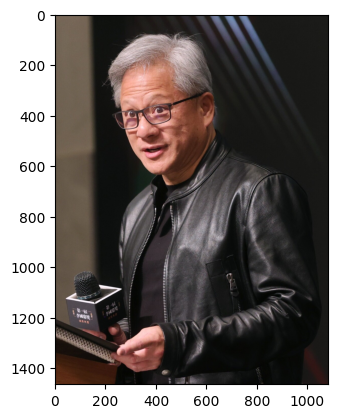

In [29]:
plt.imshow(jensen_huang[...,::-1])

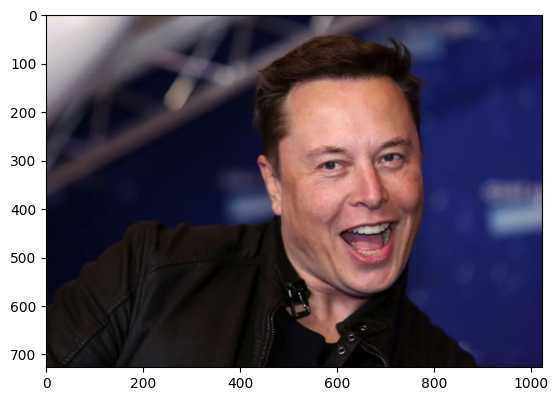

In [30]:
plt.imshow(elon_musk[...,::-1])

# Step 5: Grayscale Images

In [31]:
jensen_huang_gray = cv.cvtColor(jensen_huang, cv.COLOR_BGR2GRAY)
elon_musk_gray = cv.cvtColor(elon_musk, cv.COLOR_BGR2GRAY)

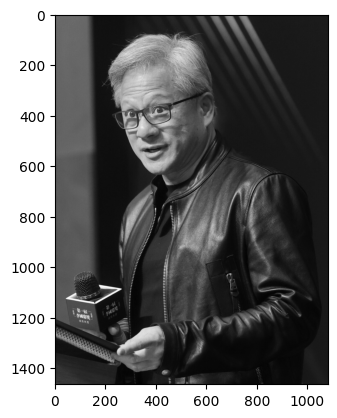

In [32]:
plt.imshow(jensen_huang_gray, cmap='gray')

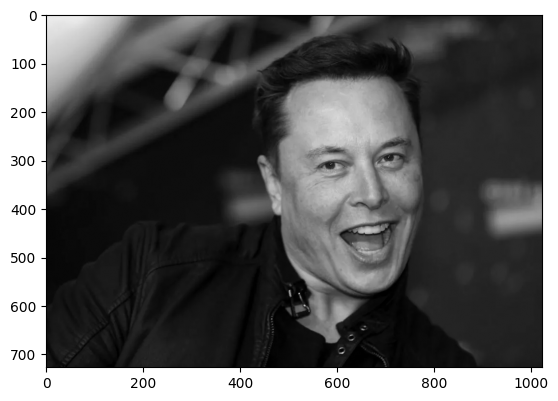

In [33]:
plt.imshow(elon_musk_gray, cmap='gray')

# Step 6: Load face detector

In [34]:
face_detector = dlib.get_frontal_face_detector()

# Step 7: Facial Landmark Predictor

In [35]:
landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Step 8: Extract Facial Landmark

In [39]:
def extract_facial_landmark(image, grayscale):
    facial_landmark = image.copy()
    faces = face_detector(grayscale)

    for face in faces:
        landmarks = landmark_predictor(grayscale, face)

        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv.circle(facial_landmark, (x, y), 5, (0, 255, 0), -1)
    return landmarks, facial_landmark

In [40]:
jensen_huang_landmarks, jensen_huang_facial_landmark = extract_facial_landmark(jensen_huang, jensen_huang_gray)
elon_musk_landmarks, elon_musk_facial_landmark = extract_facial_landmark(elon_musk, elon_musk_gray)

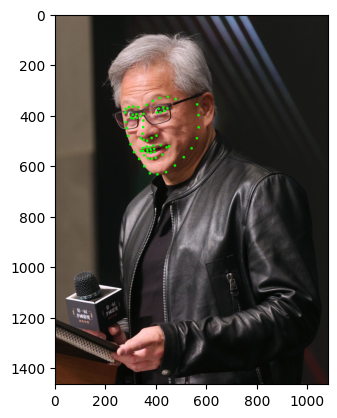

In [41]:
plt.imshow(jensen_huang_facial_landmark[...,::-1])

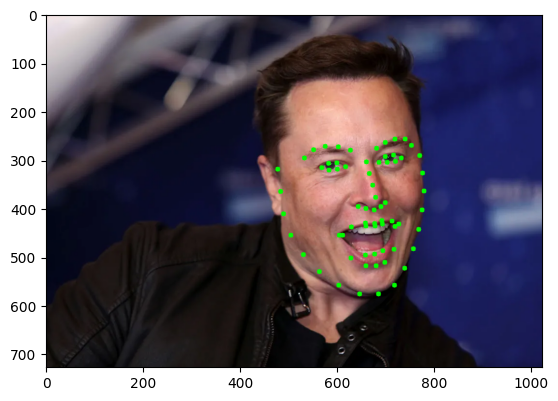

In [42]:
plt.imshow(elon_musk_facial_landmark[...,::-1])

# Step 9:

# Step X: